In [1]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models.scrambler_models_w_diff import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores


Using TensorFlow backend.


In [2]:
#Variant data parameters

isoform_pseudo_count = 1.
proximal_start = 77
proximal_end = 127


In [3]:
#Load APARENT Resnet

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode_no_drop'

save_dir = os.path.join(os.getcwd(), '../../../../autoscrambler/analysis/apa/saved_models')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)

#Re-define model for variant lor prediction
ref_input = Input(name="ref_input", shape=(1, 205, 4))
var_input = Input(name="var_input", shape=(1, 205, 4))
l_input = Input(name="l_input", shape=(13,))

ref_cut = aparent_model([ref_input, l_input])[1]
var_cut = aparent_model([var_input, l_input])[1]

def _lor(inp, iso_start=proximal_start, iso_end=proximal_end) :

    cuts_ref, cuts_var = inp
    
    y_ref = K.sum(cuts_ref[:, iso_start:iso_end], axis=-1)[:, None]
    y_var = K.sum(cuts_var[:, iso_start:iso_end], axis=-1)[:, None]
    
    y_ref = K.clip(y_ref, K.epsilon(), 1.0 - K.epsilon())
    y_var = K.clip(y_var, K.epsilon(), 1.0 - K.epsilon())

    lor = K.log(y_var / (1. - y_var)) - K.log(y_ref / (1. - y_ref))

    return lor

lor_pred = Lambda(_lor, name='lor')([ref_cut, var_cut])

predictor = Model(
    inputs=[ref_input, var_input, l_input],
    outputs=[lor_pred]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
#Load APARENT Resnet

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode_no_drop'

save_dir = os.path.join(os.getcwd(), '../../../../autoscrambler/analysis/apa/saved_models')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)

#Re-define model for variant lor prediction
ref_input = Input(name="ref_input", shape=(1, 205, 4))
l_input = Input(name="l_input", shape=(13,))

ref_cut = aparent_model([ref_input, l_input])[1]

def _iso(cuts_ref, iso_start=proximal_start, iso_end=proximal_end) :

    y_ref = K.sum(cuts_ref[:, iso_start:iso_end], axis=-1)[:, None]
    y_ref = K.clip(y_ref, K.epsilon(), 1.0 - K.epsilon())

    return y_ref

ref_iso = Lambda(_iso, name='iso')(ref_cut)

wt_predictor = Model(
    inputs=[ref_input, l_input],
    outputs=[ref_iso]
)

wt_predictor.trainable = False

wt_predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
#Load cached selected variants

sel_df = pd.read_csv("apa_variant_data_sel.csv", sep='\t', index_col=0)

sel_index = [2129, 562, 370, 3840, 3227]
full_sel_index = np.array(sel_df.index.values, dtype=np.int).tolist()

rel_index = [full_sel_index.index(sel_ix) for sel_ix in sel_index]

sel_df = sel_df.loc[sel_index]

sel_dict = np.load("apa_variant_data_sel.npz")

x_ref_sel = sel_dict["x_ref_sel"][rel_index, ...]
x_var_sel = sel_dict["x_var_sel"][rel_index, ...]

b_sel = sel_dict["b_sel"][rel_index, ...]
l_sel = sel_dict["l_sel"][rel_index, ...]

y_true_sel = sel_dict["y_true_sel"][rel_index, ...]
y_pred_sel = sel_dict["y_pred_sel"][rel_index, ...]

#Create biased background
pseudo_count = 1.0

x_mean_sel = (x_ref_sel[:, 0, ...] + pseudo_count) / (1. + 4. * pseudo_count)

#Lock background across CSE
x_mean_sel[:, 70:76, :] = np.clip(x_ref_sel[:, 0, 70:76, :], 1e-7, 1. - 1e-7)

group_sel = np.arange(x_mean_sel.shape[0])[:, None]


In [6]:
#Define sequence template and background

encoder = OneHotEncoder(seq_length=205, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

sequence_template = 'ACACGACGCTCTTCCGATCT$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$GGAGCAGATACTGGCTTAACT'

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]


In [7]:
#Run optimization with bias turned on across CSE, to reduce variance further

cse_bias = np.zeros((1, 1, 205, 1))
cse_bias[:, :, 70:76, :] = 50.


In [8]:

sel_df[['clinvar_id', 'gene', 'sitetype', 'snv_pos', 'significance', 'delta_logodds_true', 'delta_logodds_pred']]


,clinvar_id,gene,sitetype,snv_pos,significance,delta_logodds_true,delta_logodds_pred
2129,NM_024685.3(BBS10):c.*1248A>G,BBS10.2,UTR3,86,Undetermined,0.540802,0.760166
562,NM_001457.3(FLNB):c.*1450G>T,FLNB.1,UTR3,32,Undetermined,-0.659888,0.612012
370,NM_006363.5(SEC23B):c.*493A>G,SEC23B.2,UTR3,89,Undetermined,0.315566,-0.433153
3840,NM_005566.3(LDHA):c.*586A>G,LDHA.4,UTR3,33,Undetermined,0.841781,1.356996
3227,NM_145200.3(CABP4):c.*3043C>T,CABP4.1,UTR3,21,Undetermined,-0.017950,-0.353207


In [9]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 3,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : False,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    n_inputs=2,
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=205,
    n_out_channels=4,
    input_templates=[onehot_template for k in range(x_ref_sel.shape[0])],
    input_backgrounds=[x_mean_sel[k, :, :] for k in range(x_ref_sel.shape[0])],
    batch_size=1,
    n_samples=128,
    multi_input_mode='shared',
    sample_mode='gumbel',
    gumbel_temp=0.1,
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config,
    subset_size=None
)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [10]:
#Round 1: Pre-training

[pwm_ref_sel_pre, pwm_var_sel_pre], [sample_ref_sel_pre, sample_var_sel_pre], [scores_sel_pre, _], pretrain_histories = scrambler.optimize(
    predictor,
    [x_ref_sel, x_var_sel],
    np.zeros((x_ref_sel.shape[0], 1)),
    bias=[b_sel + cse_bias],
    extra_input=[l_sel],
    group=[group_sel, group_sel],
    batch_size=1,
    n_iters=100,
    norm_mode='instance',
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='target',
    entropy_bits=0.5,
    entropy_weight=1.,
    subset_size=None,
    cache_prefix_path='saved_models/apa_vars',
    load_from_cache=False,
)

#Round 2: Fine-tuning

[pwm_ref_sel_fine, pwm_var_sel_fine], [sample_ref_sel_fine, sample_var_sel_fine], [scores_sel_fine, _], finetune_histories = scrambler.optimize(
    predictor,
    [x_ref_sel, x_var_sel],
    y_true_sel,
    bias=[b_sel + cse_bias],
    extra_input=[l_sel],
    group=[group_sel, group_sel],
    batch_size=1,
    n_iters=300,
    norm_mode='instance',
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='maximization',
    entropy_bits=0.0,
    entropy_weight=1.0,
    subset_size=None,
    cache_prefix_path='saved_models/apa_vars',
    load_from_cache=True,
)


Optimizing batch 0...
Epoch 1/1
100/100 [==============================] - 66s 657ms/step - loss: 0.0286 - ft_nll_loss: 0.0280 - ft_entropy_loss: 6.1582e-04
Epoch 1/1
100/100 [==============================] - 56s 559ms/step - loss: 0.0751 - ft_nll_loss: 0.0739 - ft_entropy_loss: 0.0012
Epoch 1/1
100/100 [==============================] - 103s 1s/step - loss: 0.0783 - ft_nll_loss: 0.0773 - ft_entropy_loss: 0.0010
Epoch 1/1
100/100 [==============================] - 103s 1s/step - loss: 0.2350 - ft_nll_loss: 0.2318 - ft_entropy_loss: 0.0032
Epoch 1/1
100/100 [==============================] - 105s 1s/step - loss: 0.0694 - ft_nll_loss: 0.0688 - ft_entropy_loss: 6.4729e-04
Optimizing batch 0...
Epoch 1/1
300/300 [==============================] - 256s 853ms/step - loss: 0.1983 - ft_nll_loss: 0.0623 - ft_entropy_loss: 0.1361
Epoch 1/1
300/300 [==============================] - 308s 1s/step - loss: 0.2720 - ft_nll_loss: 0.1034 - ft_entropy_loss: 0.1686
Epoch 1/1
300/300 [===================

In [44]:
#Cache interpretations

save_suffix = '_per_example_no_drop_inference_mode_entw_1'
'''
#Store interpretations
pickle.dump({
    'pwm_ref_sel_pre' : pwm_ref_sel_pre,
    'pwm_var_sel_pre' : pwm_var_sel_pre,

    'sample_ref_sel_pre' : sample_ref_sel_pre,
    'sample_var_sel_pre' : sample_var_sel_pre,

    'scores_sel_pre' : scores_sel_pre,
    
    'pwm_ref_sel_fine' : pwm_ref_sel_fine,
    'pwm_var_sel_fine' : pwm_var_sel_fine,

    'sample_ref_sel_fine' : sample_ref_sel_fine,
    'sample_var_sel_fine' : sample_var_sel_fine,

    'scores_sel_fine' : scores_sel_fine,
}, open('apa_variants_mpra_interpretations_sel' + save_suffix + '.pickle', 'wb'))
'''

#Load interpretations
cache_dict = pickle.load(open('apa_variants_mpra_interpretations_sel' + save_suffix + '.pickle', 'rb'))

pwm_ref_sel_pre = cache_dict['pwm_ref_sel_pre']
pwm_var_sel_pre = cache_dict['pwm_var_sel_pre']

sample_ref_sel_pre = cache_dict['sample_ref_sel_pre']
sample_var_sel_pre = cache_dict['sample_var_sel_pre']

scores_sel_pre = cache_dict['scores_sel_pre']

pwm_ref_sel_fine = cache_dict['pwm_ref_sel_fine']
pwm_var_sel_fine = cache_dict['pwm_var_sel_fine']

sample_ref_sel_fine = cache_dict['sample_ref_sel_fine']
sample_var_sel_fine = cache_dict['sample_var_sel_fine']

scores_sel_fine = cache_dict['scores_sel_fine']


In [45]:
#Mask out USE and DSE regions (do not consider CSE)
sequence_mask_no_cse = np.copy(sequence_mask)
sequence_mask_no_cse[70:76] = 0.

#Subtract biases
scores_sel_fine = scores_sel_fine - b_sel - cse_bias

scores_sel_fine *= sequence_mask_no_cse[None, None, :, None]

#Normalize to max score = 1
scores_sel_fine /= np.max(scores_sel_fine, axis=(1, 2, 3), keepdims=True)


In [46]:
#Cache scores
save_name = 'apa_vars_resnet_mpra_scrambler_shared_per_example_entw_1'

np.save(save_name + '_ref_scores', scores_sel_fine)
np.save(save_name + '_var_scores', scores_sel_fine)
np.save(save_name + '_scores', scores_sel_fine)

#Load scores

scores_sel_fine = np.load(save_name + '_scores.npy')


Sequence 2129:
 - Abs Prediction (original ref) = 0.1570
 - Abs Prediction (original var) = 0.2907
 - Abs Prediction (scrambled ref) = 0.2307
 - Abs Prediction (scrambled var) = 0.3370

 - Prediction (original) = 0.7887
 - Prediction (scrambled) = 0.6719


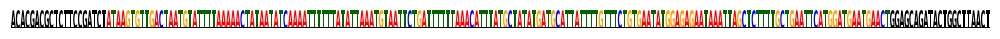

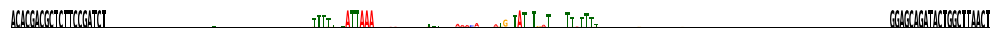

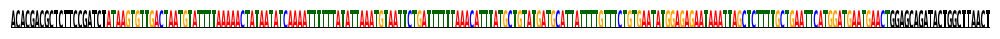

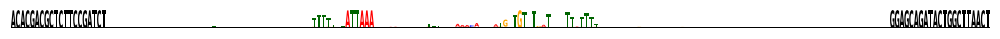

Net Scores:


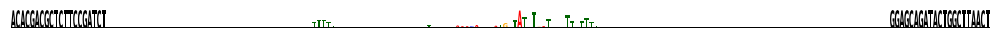

Sequence 562:
 - Abs Prediction (original ref) = 0.6540
 - Abs Prediction (original var) = 0.7803
 - Abs Prediction (scrambled ref) = 0.3587
 - Abs Prediction (scrambled var) = 0.4747

 - Prediction (original) = 0.6308
 - Prediction (scrambled) = 0.4911


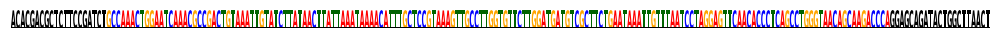

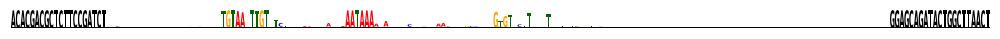

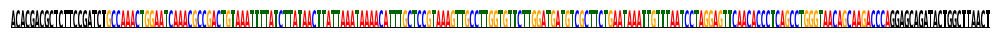

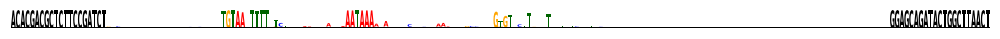

Net Scores:


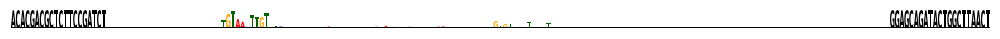

Sequence 370:
 - Abs Prediction (original ref) = 0.0551
 - Abs Prediction (original var) = 0.0329
 - Abs Prediction (scrambled ref) = 0.0472
 - Abs Prediction (scrambled var) = 0.0369

 - Prediction (original) = -0.537
 - Prediction (scrambled) = -0.414


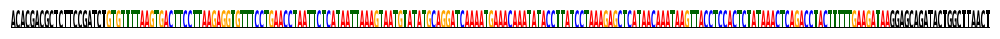

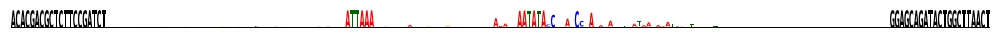

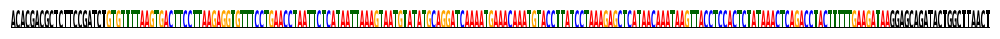

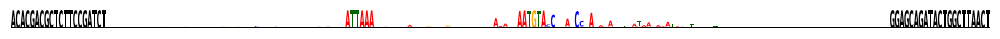

Net Scores:


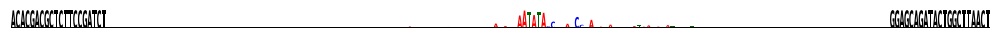

Sequence 3840:
 - Abs Prediction (original ref) = 0.0265
 - Abs Prediction (original var) = 0.0988
 - Abs Prediction (scrambled ref) = 0.0250
 - Abs Prediction (scrambled var) = 0.0697

 - Prediction (original) = 1.3935
 - Prediction (scrambled) = 1.2417


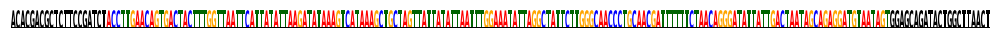

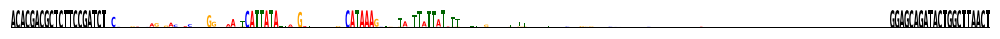

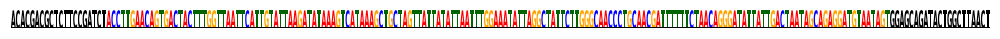

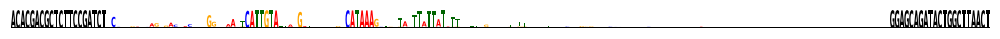

Net Scores:


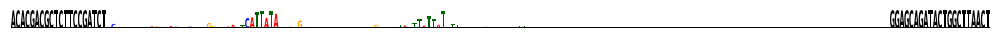

Sequence 3227:
 - Abs Prediction (original ref) = 0.2494
 - Abs Prediction (original var) = 0.1632
 - Abs Prediction (scrambled ref) = 0.2006
 - Abs Prediction (scrambled var) = 0.1634

 - Prediction (original) = -0.532
 - Prediction (scrambled) = -0.440


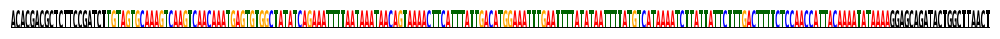

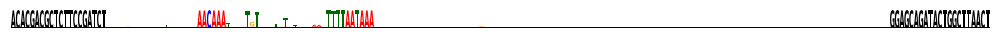

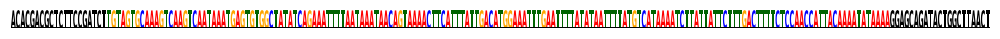

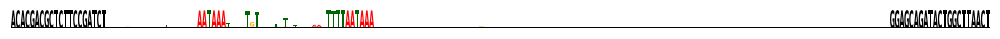

Net Scores:


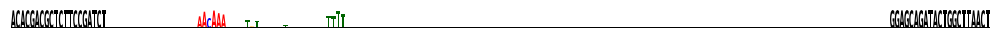

In [47]:
#Visualize a few reconstructed sequence patterns

model_name = "apa_vars_shared_per_example_entw_1"

pwm_ref_sel_no_bg = (2. * x_ref_sel - 1.) * scores_sel_fine * sequence_mask[None, None, :, None]
pwm_ref_sel_no_bg = np.exp(pwm_ref_sel_no_bg) / np.sum(np.exp(pwm_ref_sel_no_bg), axis=-1)[..., None]

pwm_var_sel_no_bg = (2. * x_var_sel - 1.) * scores_sel_fine * sequence_mask[None, None, :, None]
pwm_var_sel_no_bg = np.exp(pwm_var_sel_no_bg) / np.sum(np.exp(pwm_var_sel_no_bg), axis=-1)[..., None]

#Collect actual discrete samples (not_gumbel)
n_samples = 128

sample_cols = np.arange(n_samples, dtype=np.int)
nts = np.arange(4, dtype=np.int)

sample_ref_sel_hard = np.zeros((pwm_ref_sel_fine.shape[0], 128, 1, 205, 4))
for i in range(pwm_ref_sel_fine.shape[0]) :
    for j in range(205) :
        sampled_ixs = np.random.choice(nts, size=n_samples, p=pwm_ref_sel_fine[i, 0, j, :])
        sample_ref_sel_hard[i, sample_cols, 0, j, sampled_ixs] = 1. 

sample_var_sel_hard = np.zeros((pwm_var_sel_fine.shape[0], 128, 1, 205, 4))
for i in range(pwm_var_sel_fine.shape[0]) :
    for j in range(205) :
        sampled_ixs = np.random.choice(nts, size=n_samples, p=pwm_var_sel_fine[i, 0, j, :])
        sample_var_sel_hard[i, sample_cols, 0, j, sampled_ixs] = 1. 

sample_ref_sel_hard_mut = np.copy(sample_ref_sel_hard)
mut_pos_sel = np.argmax(np.max(x_ref_sel[:, 0, ...] - x_var_sel[:, 0, ...], axis=-1), axis=-1)
for i in range(sample_ref_sel_hard_mut.shape[0]) :
    sample_ref_sel_hard_mut[i, :, 0, mut_pos_sel[i], :] = x_var_sel[i, 0, mut_pos_sel[i], :]

sample_var_sel_hard_mut = np.copy(sample_var_sel_hard)
mut_pos_sel = np.argmax(np.max(x_ref_sel[:, 0, ...] - x_var_sel[:, 0, ...], axis=-1), axis=-1)
for i in range(sample_var_sel_hard_mut.shape[0]) :
    sample_var_sel_hard_mut[i, :, 0, mut_pos_sel[i], :] = x_ref_sel[i, 0, mut_pos_sel[i], :]

plot_examples = [2129, 562, 370, 3840, 3227]
save_examples = [2129, 562, 370, 3840, 3227]

q_thresh = 1.0

for plot_i in range(x_ref_sel.shape[0]) :
    
    if sel_index[plot_i] not in plot_examples :
        continue
    
    print("Sequence " + str(sel_index[plot_i]) + ":")
    
    iso_ref_sel = wt_predictor.predict(x=[x_ref_sel[plot_i:plot_i+1], l_sel[plot_i:plot_i+1]], batch_size=1)[0, 0]
    iso_var_sel = wt_predictor.predict(x=[x_var_sel[plot_i:plot_i+1], l_sel[plot_i:plot_i+1]], batch_size=1)[0, 0]
    
    iso_ref_scrambled_sel = wt_predictor.predict(x=[sample_ref_sel_hard[plot_i], np.tile(l_sel[plot_i:plot_i+1], (sample_ref_sel_hard.shape[1], 1))], batch_size=32)[:, 0]
    iso_var_scrambled_sel = wt_predictor.predict(x=[sample_var_sel_hard[plot_i], np.tile(l_sel[plot_i:plot_i+1], (sample_ref_sel_hard.shape[1], 1))], batch_size=32)[:, 0]
    
    
    lor_sel = predictor.predict(x=[x_ref_sel[plot_i:plot_i+1], x_var_sel[plot_i:plot_i+1], l_sel[plot_i:plot_i+1]], batch_size=1)[0, 0]
    lor_scrambled_sel_fine = np.mean(predictor.predict(x=[sample_ref_sel_hard[plot_i], sample_ref_sel_hard_mut[plot_i], np.tile(l_sel[plot_i:plot_i+1], (sample_ref_sel_hard.shape[1], 1))], batch_size=32)[:, 0])
    
    print(" - Abs Prediction (original ref) = " + str(round(iso_ref_sel, 6))[:6])
    print(" - Abs Prediction (original var) = " + str(round(iso_var_sel, 6))[:6])
    print(" - Abs Prediction (scrambled ref) = " + str(round(np.mean(iso_ref_scrambled_sel), 6))[:6])
    print(" - Abs Prediction (scrambled var) = " + str(round(np.mean(iso_var_scrambled_sel), 6))[:6])
    
    print("")
    
    print(" - Prediction (original) = " + str(round(lor_sel, 6))[:6])
    print(" - Prediction (scrambled) = " + str(round(lor_scrambled_sel_fine, 6))[:6])
    
    save_figs = False
    if save_examples is not None and sel_index[plot_i] in save_examples :
        save_figs = True
    
    score_clip = np.quantile(scores_sel_fine[plot_i, 0, :, :], q=q_thresh)
    
    plot_dna_logo(x_ref_sel[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_ref")
    plot_dna_logo(pwm_ref_sel_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_ref" + "_pwm")
    
    plot_dna_logo(x_var_sel[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_var")
    plot_dna_logo(pwm_var_sel_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_var" + "_pwm")
    
    print("Net Scores:")
    plot_dna_importance_scores(scores_sel_fine[plot_i, 0, :, :].T, encoder.decode(x_ref_sel[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_scores")
    

Sequence 2129:
 - Abs Prediction (original ref) = 0.1570
 - Abs Prediction (original var) = 0.2907
 - Abs Prediction (scrambled ref) = 0.1653
 - Abs Prediction (scrambled var) = 0.2677

 - Prediction (original) = 0.7887
 - Prediction (scrambled) = 0.6590


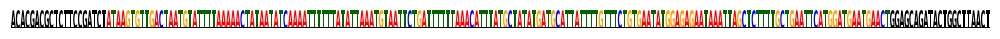

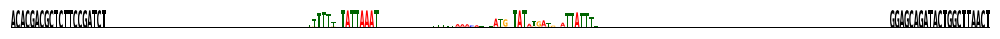

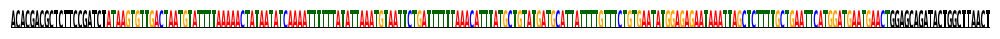

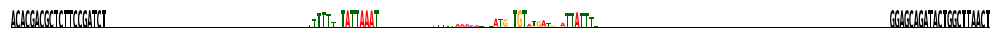

Net Scores:


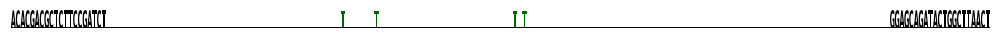

Sequence 562:
 - Abs Prediction (original ref) = 0.6540
 - Abs Prediction (original var) = 0.7803
 - Abs Prediction (scrambled ref) = 0.3476
 - Abs Prediction (scrambled var) = 0.4602

 - Prediction (original) = 0.6308
 - Prediction (scrambled) = 0.4828


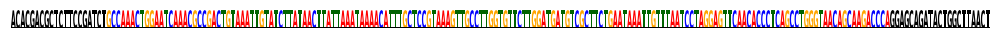

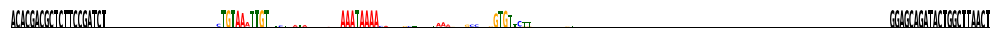

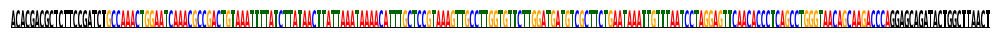

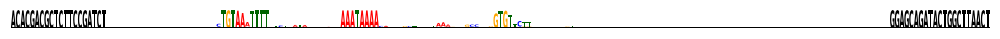

Net Scores:


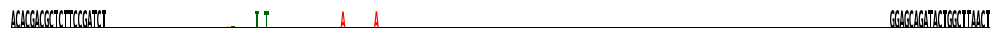

Sequence 370:
 - Abs Prediction (original ref) = 0.0551
 - Abs Prediction (original var) = 0.0329
 - Abs Prediction (scrambled ref) = 0.0600
 - Abs Prediction (scrambled var) = 0.0471

 - Prediction (original) = -0.537
 - Prediction (scrambled) = -0.365


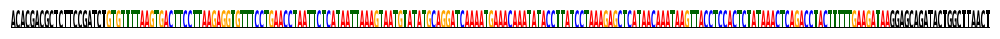

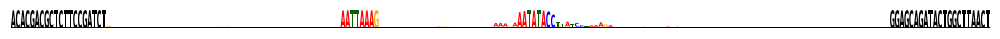

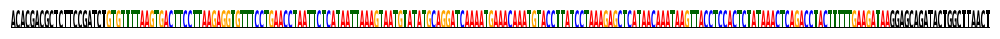

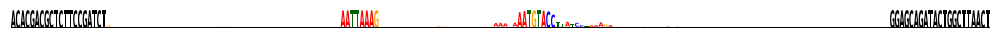

Net Scores:


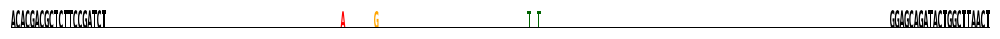

Sequence 3840:
 - Abs Prediction (original ref) = 0.0265
 - Abs Prediction (original var) = 0.0988
 - Abs Prediction (scrambled ref) = 0.0275
 - Abs Prediction (scrambled var) = 0.0739

 - Prediction (original) = 1.3935
 - Prediction (scrambled) = 1.2504


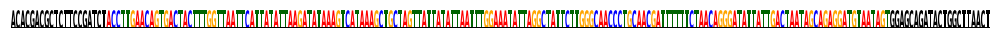

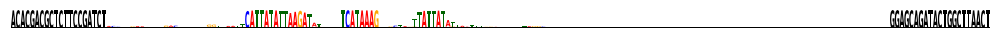

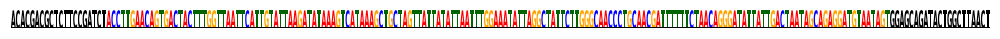

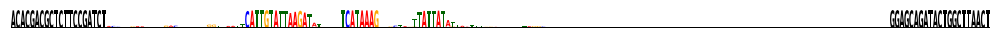

Net Scores:


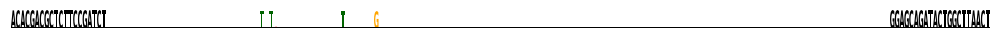

Sequence 3227:
 - Abs Prediction (original ref) = 0.2494
 - Abs Prediction (original var) = 0.1632
 - Abs Prediction (scrambled ref) = 0.2368
 - Abs Prediction (scrambled var) = 0.1458

 - Prediction (original) = -0.532
 - Prediction (scrambled) = -0.453


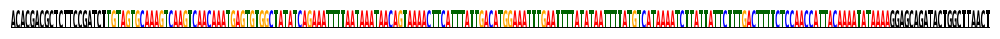

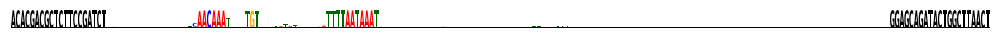

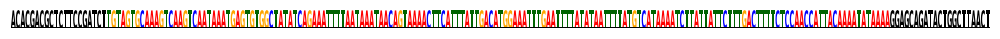

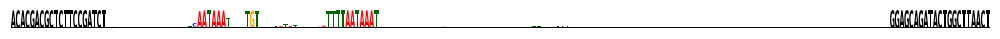

Net Scores:


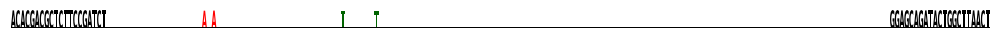

In [22]:
#Visualize a few reconstructed sequence patterns

model_name = "apa_vars_shared_per_example_entw_1_smooth"

pwm_ref_sel_no_bg = (2. * x_ref_sel - 1.) * scores_sel_fine * sequence_mask[None, None, :, None]
pwm_ref_sel_no_bg = np.exp(pwm_ref_sel_no_bg) / np.sum(np.exp(pwm_ref_sel_no_bg), axis=-1)[..., None]

pwm_var_sel_no_bg = (2. * x_var_sel - 1.) * scores_sel_fine * sequence_mask[None, None, :, None]
pwm_var_sel_no_bg = np.exp(pwm_var_sel_no_bg) / np.sum(np.exp(pwm_var_sel_no_bg), axis=-1)[..., None]

#Collect actual discrete samples (not_gumbel)
n_samples = 128

sample_cols = np.arange(n_samples, dtype=np.int)
nts = np.arange(4, dtype=np.int)

sample_ref_sel_hard = np.zeros((pwm_ref_sel_fine.shape[0], 128, 1, 205, 4))
for i in range(pwm_ref_sel_fine.shape[0]) :
    for j in range(205) :
        sampled_ixs = np.random.choice(nts, size=n_samples, p=pwm_ref_sel_fine[i, 0, j, :])
        sample_ref_sel_hard[i, sample_cols, 0, j, sampled_ixs] = 1. 

sample_var_sel_hard = np.zeros((pwm_var_sel_fine.shape[0], 128, 1, 205, 4))
for i in range(pwm_var_sel_fine.shape[0]) :
    for j in range(205) :
        sampled_ixs = np.random.choice(nts, size=n_samples, p=pwm_var_sel_fine[i, 0, j, :])
        sample_var_sel_hard[i, sample_cols, 0, j, sampled_ixs] = 1. 

sample_ref_sel_hard_mut = np.copy(sample_ref_sel_hard)
mut_pos_sel = np.argmax(np.max(x_ref_sel[:, 0, ...] - x_var_sel[:, 0, ...], axis=-1), axis=-1)
for i in range(sample_ref_sel_hard_mut.shape[0]) :
    sample_ref_sel_hard_mut[i, :, 0, mut_pos_sel[i], :] = x_var_sel[i, 0, mut_pos_sel[i], :]

sample_var_sel_hard_mut = np.copy(sample_var_sel_hard)
mut_pos_sel = np.argmax(np.max(x_ref_sel[:, 0, ...] - x_var_sel[:, 0, ...], axis=-1), axis=-1)
for i in range(sample_var_sel_hard_mut.shape[0]) :
    sample_var_sel_hard_mut[i, :, 0, mut_pos_sel[i], :] = x_ref_sel[i, 0, mut_pos_sel[i], :]

plot_examples = [2129, 562, 370, 3840, 3227]
save_examples = [2129, 562, 370, 3840, 3227]

q_thresh = 1.0

for plot_i in range(x_ref_sel.shape[0]) :
    
    if sel_index[plot_i] not in plot_examples :
        continue
    
    print("Sequence " + str(sel_index[plot_i]) + ":")
    
    iso_ref_sel = wt_predictor.predict(x=[x_ref_sel[plot_i:plot_i+1], l_sel[plot_i:plot_i+1]], batch_size=1)[0, 0]
    iso_var_sel = wt_predictor.predict(x=[x_var_sel[plot_i:plot_i+1], l_sel[plot_i:plot_i+1]], batch_size=1)[0, 0]
    
    iso_ref_scrambled_sel = wt_predictor.predict(x=[sample_ref_sel_hard[plot_i], np.tile(l_sel[plot_i:plot_i+1], (sample_ref_sel_hard.shape[1], 1))], batch_size=32)[:, 0]
    iso_var_scrambled_sel = wt_predictor.predict(x=[sample_var_sel_hard[plot_i], np.tile(l_sel[plot_i:plot_i+1], (sample_ref_sel_hard.shape[1], 1))], batch_size=32)[:, 0]
    
    
    lor_sel = predictor.predict(x=[x_ref_sel[plot_i:plot_i+1], x_var_sel[plot_i:plot_i+1], l_sel[plot_i:plot_i+1]], batch_size=1)[0, 0]
    lor_scrambled_sel_fine = np.mean(predictor.predict(x=[sample_ref_sel_hard[plot_i], sample_ref_sel_hard_mut[plot_i], np.tile(l_sel[plot_i:plot_i+1], (sample_ref_sel_hard.shape[1], 1))], batch_size=32)[:, 0])
    
    print(" - Abs Prediction (original ref) = " + str(round(iso_ref_sel, 6))[:6])
    print(" - Abs Prediction (original var) = " + str(round(iso_var_sel, 6))[:6])
    print(" - Abs Prediction (scrambled ref) = " + str(round(np.mean(iso_ref_scrambled_sel), 6))[:6])
    print(" - Abs Prediction (scrambled var) = " + str(round(np.mean(iso_var_scrambled_sel), 6))[:6])
    
    print("")
    
    print(" - Prediction (original) = " + str(round(lor_sel, 6))[:6])
    print(" - Prediction (scrambled) = " + str(round(lor_scrambled_sel_fine, 6))[:6])
    
    save_figs = False
    if save_examples is not None and sel_index[plot_i] in save_examples :
        save_figs = True
    
    score_clip = np.quantile(scores_sel_fine[plot_i, 0, :, :], q=q_thresh)
    
    plot_dna_logo(x_ref_sel[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_ref")
    plot_dna_logo(pwm_ref_sel_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_ref" + "_pwm")
    
    plot_dna_logo(x_var_sel[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_var")
    plot_dna_logo(pwm_var_sel_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_var" + "_pwm")
    
    print("Net Scores:")
    plot_dna_importance_scores(scores_sel_fine[plot_i, 0, :, :].T, encoder.decode(x_ref_sel[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_scores")
